# 2D Poisson problem

We rewrite [Example 17](https://github.com/kinnala/scikit-fem/blob/11.0.0/docs/examples/ex17.py) in a mesh-agnostic way after defining the mesh externally via `gmsh`.

In [1]:
import skfem
from skfem.helpers import grad, dot
from skfem.models.poisson import mass, unit_load
from skfem.visuals.matplotlib import draw, plot
import gmsh

## Mesh

In [2]:
# Initiate mesh
gmsh.initialize()
gmsh.model.add("Omega")

occ = gmsh.model.occ

small_c = occ.add_circle(0, 0, 0, 2)
small_loop = occ.add_curve_loop([small_c])
core = occ.add_plane_surface([small_loop])
big_c = occ.add_circle(0, 0, 0, 3)
big_loop = occ.add_curve_loop([big_c])
ring = occ.add_plane_surface([big_loop, small_loop])
occ.synchronize()

# uncomment for gmsh GUI
# gmsh.fltk.run()

gmsh.model.add_physical_group(2, [core], tag=1, name="core")
gmsh.model.add_physical_group(2, [ring], tag=2, name="ring")
gmsh.model.add_physical_group(1, [big_c], tag=3, name="boundary")

# Specify mesh options and generate the mesh.
gmsh.option.setNumber("Mesh.MeshSizeMax", 0.2)
gmsh.option.setNumber("Mesh.RecombineAll", 1)
gmsh.model.mesh.generate(2)

# We write the mesh to a file
gmsh.write("disk.msh")
gmsh.finalize()

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [ 60%] Meshing curve 2 (Circle)
Info    : Done meshing 1D (Wall 0.000228427s, CPU 0.000376s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [  0%] Blossom: 1138 internal 64 closed
Info    : [  0%] Blossom recombination completed (Wall 0.012982s, CPU 0.013049s): 389 quads, 0 triangles, 0 invalid quads, 0 quads with Q < 0.1, avg Q = 0.79592, min Q = 0.512985
Info    : [ 60%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : [ 60%] Blossom: 1420 internal 160 closed
Info    : [ 60%] Blossom recombination completed (Wall 0.0213551s, CPU 0.02143s): 498 quads, 0 triangles, 0 invalid quads, 0 quads with Q < 0.1, avg Q = 0.770335, min Q = 0.486656
Info    : Done meshing 2D (Wall 0.0933052s, CPU 0.094029s)
Info    : 936 nodes 1049 elements
Info    : Writing 'disk.msh'...
Info    : Done writing 'disk.msh'


In [3]:
mesh = skfem.mesh.Mesh.load("./disk.msh")
mesh.subdomains.pop("gmsh:bounding_entities", None)
print(mesh)


<skfem MeshQuad1 object>
  Number of elements: 887
  Number of vertices: 936
  Number of nodes: 936
  Named subdomains [# elements]: core [389], ring [498]
  Named boundaries [# facets]: boundary [96]


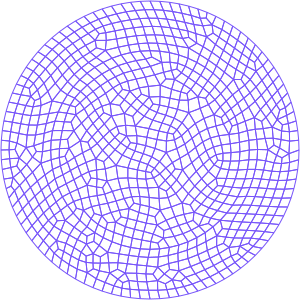

In [4]:
mesh

## Solving the problem

We start by setting the parameters: `k_values` contains the values of the thermal conductivity in the core and in the outside ring, `A` is the Joule heating, and `h` is the heat transfer.

In [5]:
k_values = {'core': 101.,  'ring': 11.}
A = 5.
h = 7.

We create bases for Quadratic elements of degree 1 and 0.

In [6]:
basis1 = skfem.Basis(mesh, skfem.ElementQuad1())
basis0 = basis1.with_element(skfem.ElementQuad0())

Next, we create a function `k` constant on all the elements.

In [7]:
k = basis0.zeros()
for s in mesh.subdomains:
    k[basis0.get_dofs(elements=s)] = k_values[s]

Then we assemble the FEM and solve the linear problem.

In [8]:
@skfem.BilinearForm
def conduction(u, v, w):
    return w.k * dot(grad(u), grad(v))
S = conduction.assemble(basis1, k=basis0.interpolate(k))

facet_basis = skfem.FacetBasis(mesh, basis1.elem, facets=mesh.boundaries['boundary'])
H = h * skfem.asm(mass, facet_basis)

core_basis = skfem.Basis(mesh, basis1.elem, elements=mesh.subdomains['core'])
b = A * skfem.asm(unit_load, core_basis)

temperature = skfem.solve(S + H, b)

<Axes: >

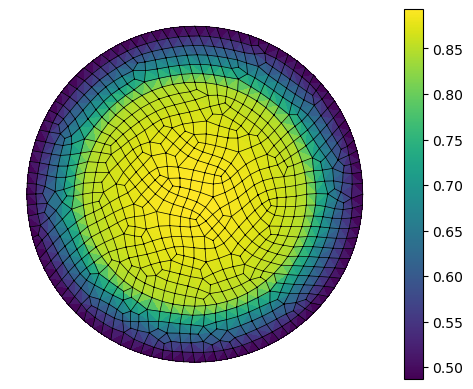

In [9]:
ax = draw(mesh)
plot(mesh, temperature, ax=ax, colorbar=True, cmap="viridis")